In [2]:
import requests
import time
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy
from dotenv import load_dotenv
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
host = os.getenv('HOST')
port = os.getenv('PORT')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
database= os.getenv('DATABASE')

In [13]:
# Verbindung zur Datenbank herstellen
connection = psycopg2.connect(host=host, port=port, database=database, user=user, password=password)
print("Verbindung zur Datenbank erfolgreich hergestellt.")

# Einen Cursor erstellen, um SQL-Abfragen auszuführen
cursor = connection.cursor()

# SQL SELECT-Abfrage
select_query = "SELECT * FROM value;"

# Abfrage ausführen
cursor.execute(select_query)

# Ergebnis abrufen
rows = cursor.fetchall()

# Ergebnis in ein Pandas DataFrame umwandeln
df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])

# Cursor und Verbindung schließen
cursor.close()
connection.close()


Verbindung zur Datenbank erfolgreich hergestellt.


In [49]:
df_n = df[df["senseid_fk"]=="5c08379b1c28f9001a3f580c"]

In [50]:
df_n.sort_values(by="time", ascending=True, inplace=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_13532\3766418188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n.sort_values(by="time", ascending=True, inplace=True)


In [51]:
df_n.set_index('time', inplace=True)
df_n = df_n.drop(columns={"index","senseid_fk"},axis=1)

<Axes: xlabel='time'>

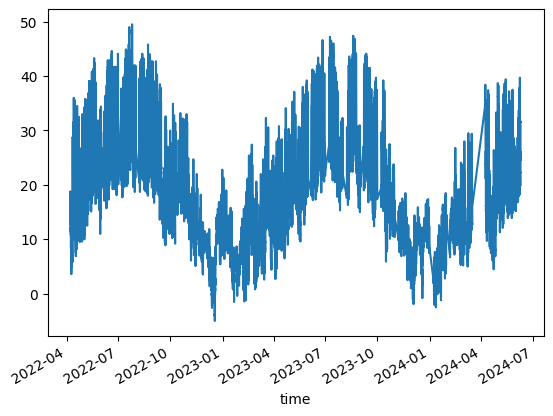

In [52]:
df_n.temperature.plot()

In [53]:
# Resample auf 10-Minuten-Rhythmus
df_n = df_n.resample('10T').mean()

# Fehlende Werte auffüllen (optional)
df_n.interpolate(method='time', inplace=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_13532\2127068512.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_n = df_n.resample('10T').mean()


In [54]:
from statsmodels.tsa.stattools import adfuller

# Annahme: df_n ist Ihr DataFrame mit der Zeitreihe
# Hier nehmen wir an, dass die Temperatur in der Spalte 'temperature' gespeichert ist

# Führen Sie den ADF-Test durch
result = adfuller(df_n['temperature'])

# Ergebnisse ausgeben
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -11.542453277108129
p-value: 3.6070037941220765e-21
Critical Values:
   1%: -3.4304071305346917
   5%: -2.8615652508364353
   10%: -2.5667834401305223


In [55]:
df_n = df_n.drop(columns={'luftfeuchtigkeit','pm10', 'pm2_5'}, axis=1)

In [56]:
df_n

,temperature
time,
2022-04-07 00:00:00,13.666667
2022-04-07 00:10:00,13.500000
2022-04-07 00:20:00,13.450000
2022-04-07 00:30:00,13.266667
2022-04-07 00:40:00,13.200000
...,...
2024-06-10 08:30:00,31.600000
2024-06-10 08:40:00,31.600000
2024-06-10 08:50:00,31.600000


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sicherstellen, dass eine GPU verfügbar ist
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [33]:
# Werte extrahieren
data = df_n['temperature'].values

In [34]:
# Daten skalieren
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

In [35]:
# Zeitreihen-Daten in 3D-Format umwandeln [samples, time_steps, features]
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 144
X, y = create_sequences(data_scaled, time_steps)

# Trainings- und Testdaten aufteilen
# Verwenden Sie die letzten 144 Werte für das Training
train_size = len(X) - 144
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# In Torch-Tensoren konvertieren
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


In [36]:
# LSTM Modell definieren
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [37]:
# Modell initialisieren
input_size = 1  # Da wir nur die Temperatur als Merkmal haben
hidden_size = 50
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Verlustfunktion und Optimierer definieren
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modell trainieren
num_epochs = 20
batch_size = 32

In [38]:
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        outputs = model(X_batch.unsqueeze(-1))
        optimizer.zero_grad()
        loss = criterion(outputs, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0000
Epoch [2/20], Loss: 0.0001
Epoch [3/20], Loss: 0.0000
Epoch [4/20], Loss: 0.0000
Epoch [5/20], Loss: 0.0002
Epoch [6/20], Loss: 0.0001
Epoch [7/20], Loss: 0.0001
Epoch [8/20], Loss: 0.0001
Epoch [9/20], Loss: 0.0001
Epoch [10/20], Loss: 0.0001
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0000
Epoch [14/20], Loss: 0.0000
Epoch [15/20], Loss: 0.0000
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


In [40]:
# Modell bewerten
model.eval()
with torch.no_grad():
    y_pred = model(X_test.unsqueeze(-1)).cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()
    
    # MAE
    mae = mean_absolute_error(y_test_cpu, y_pred)
    # RMSE
    rmse = mean_squared_error(y_test_cpu, y_pred, squared=False)
    # R^2
    r2 = r2_score(y_test_cpu, y_pred)
    
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error (MAE): 0.0325
Root Mean Squared Error (RMSE): 0.0340
R^2 Score: -81544085504.0000


c:\Users\mariu\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [57]:
# Annahme: 'model' ist Ihr trainiertes LSTM-Modell

# Speichern des Modells
torch.save(model.state_dict(), 'lstm_model.pth')

In [58]:
# Modell laden
test = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
test.load_state_dict(torch.load('lstm_model.pth'))

<All keys matched successfully>

<Axes: xlabel='time'>

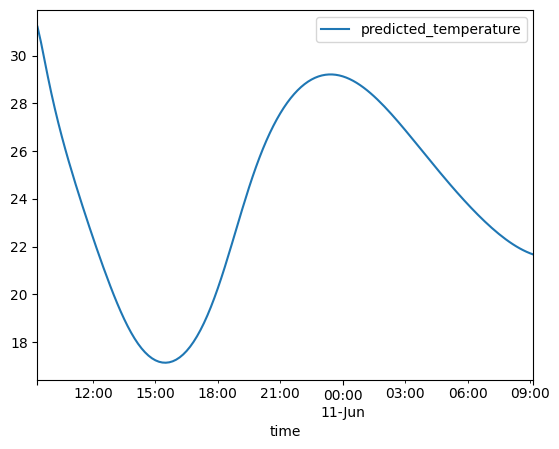

In [64]:
# Nächste 144 Werte vorhersagen
test.eval()
with torch.no_grad():
    # Startpunkt: Die letzten 144 Werte aus dem Testset
    last_sequence = X_test[-1]
    predictions = []
    
    current_seq = last_sequence.unsqueeze(0).unsqueeze(-1)  # [1, 144, 1]
    for _ in range(144):
        with torch.no_grad():
            next_pred = model(current_seq).cpu().numpy().flatten()
            predictions.append(next_pred)
            next_value = torch.tensor(next_pred, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(-1)
            current_seq = torch.cat((current_seq[:, 1:, :], next_value), dim=1)
    
    # Inverse Transformation, falls gewünscht
    predictions = np.array(predictions).flatten()
    predictions_original_scale = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Erstellen eines neuen DataFrames mit den Vorhersagen und den Zeitstempeln
    last_time = df_n.index[-1]
    prediction_times = [last_time + pd.Timedelta(minutes=10*(i+1)) for i in range(144)]
    predictions_df = pd.DataFrame({
        'time': prediction_times,
        'predicted_temperature': predictions_original_scale
    })

predictions_df.plot(x="time",y="predicted_temperature")